In [195]:
import matplotlib as mpl
from numpy import *
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
import matplotlib.pyplot as plt

In [196]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D:\Anoconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [197]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [198]:
def build_network():
    # 先创建包含多网络层的列表
    conv_layers = [
        layers.Conv1D(filters=128, kernel_size=1, padding='same', activation=tf.nn.relu),
        layers.Dropout(0.5),
        layers.MaxPooling1D(2),
        layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        layers.Dropout(0.5),
        layers.MaxPooling1D(2),
        layers.Conv1D(filters=128, kernel_size=9, padding='same', activation=tf.nn.relu),
        layers.MaxPooling1D(2),
        layers.Dropout(0.5)
    ]

    fc_layers = [
        layers.Dense(64, activation=tf.nn.relu),  # 全连接层， 64 个节点
        layers.GlobalAveragePooling1D(),
        layers.Dense(1, activation=tf.nn.sigmoid)  # 全连接层， 1 个节点
    ]

    conv_layers.extend(fc_layers)
    network = Sequential(conv_layers)
    network.build(input_shape=[None, 41, 21])#[None, 41, 21]
    base_learning_rate = 0.001
    network.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #network.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    #network.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    network.summary()
    return network

In [199]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [200]:
batch_size=256

In [201]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [202]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [203]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [204]:
prediction_result_cv = []
prediction_result_ind = []

In [205]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据')

In [206]:
out = os.getcwd() + '\\'

In [207]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    network = build_network()
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = network.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = network.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = network.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_240 (Conv1D)          (None, 41, 128)           2816      
_________________________________________________________________
dropout_240 (Dropout)        (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d_240 (MaxPoolin (None, 20, 128)           0         
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 20, 128)           49280     
_________________________________________________________________
dropout_241 (Dropout)        (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_241 (MaxPoolin (None, 10, 128)           0         
_________________________________________________________________
conv1d_242 (Conv1D)          (None, 10, 128)         

8/8 - 0s - loss: 0.6245 - accuracy: 0.6490 - val_loss: 0.6553 - val_accuracy: 0.6356

Epoch 00033: val_loss did not improve from 0.65464
Epoch 34/300
8/8 - 0s - loss: 0.6367 - accuracy: 0.6461 - val_loss: 0.6496 - val_accuracy: 0.6311

Epoch 00034: val_loss improved from 0.65464 to 0.64955, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_0.h5
Epoch 35/300
8/8 - 0s - loss: 0.6267 - accuracy: 0.6456 - val_loss: 0.6564 - val_accuracy: 0.5911

Epoch 00035: val_loss did not improve from 0.64955
Epoch 36/300
8/8 - 0s - loss: 0.6222 - accuracy: 0.6525 - val_loss: 0.6472 - val_accuracy: 0.6400

Epoch 00036: val_loss improved from 0.64955 to 0.64718, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_0.h5
Epoch 37/300
8/8 - 0s - loss: 0.6262 - accuracy: 0.6421 - val_loss: 0.6530 - val_accuracy: 0.6489

Epoch 00037: val_loss did not improve from 0.64718
Epoch 38/300
8/8 - 0s - loss: 0.6


Epoch 00076: val_loss did not improve from 0.57728
Epoch 77/300
8/8 - 0s - loss: 0.5214 - accuracy: 0.7346 - val_loss: 0.6159 - val_accuracy: 0.6267

Epoch 00077: val_loss did not improve from 0.57728
Epoch 78/300
8/8 - 0s - loss: 0.5350 - accuracy: 0.7237 - val_loss: 0.5866 - val_accuracy: 0.6800

Epoch 00078: val_loss did not improve from 0.57728
Epoch 79/300
8/8 - 0s - loss: 0.5073 - accuracy: 0.7459 - val_loss: 0.5759 - val_accuracy: 0.6711

Epoch 00079: val_loss improved from 0.57728 to 0.57587, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_0.h5
Epoch 80/300
8/8 - 0s - loss: 0.4906 - accuracy: 0.7514 - val_loss: 0.5793 - val_accuracy: 0.7067

Epoch 00080: val_loss did not improve from 0.57587
Epoch 81/300
8/8 - 0s - loss: 0.5388 - accuracy: 0.7257 - val_loss: 0.5728 - val_accuracy: 0.7111

Epoch 00081: val_loss improved from 0.57587 to 0.57275, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\


Epoch 00124: val_loss did not improve from 0.53295
Epoch 125/300
8/8 - 0s - loss: 0.4130 - accuracy: 0.8057 - val_loss: 0.5560 - val_accuracy: 0.7067

Epoch 00125: val_loss did not improve from 0.53295
Epoch 126/300
8/8 - 0s - loss: 0.3688 - accuracy: 0.8339 - val_loss: 0.5466 - val_accuracy: 0.7022

Epoch 00126: val_loss did not improve from 0.53295
Epoch 127/300
8/8 - 0s - loss: 0.4123 - accuracy: 0.8062 - val_loss: 0.5848 - val_accuracy: 0.6800

Epoch 00127: val_loss did not improve from 0.53295
Epoch 128/300
8/8 - 0s - loss: 0.3605 - accuracy: 0.8423 - val_loss: 0.5369 - val_accuracy: 0.7067

Epoch 00128: val_loss did not improve from 0.53295
Epoch 129/300
8/8 - 0s - loss: 0.4064 - accuracy: 0.8023 - val_loss: 0.5465 - val_accuracy: 0.6933

Epoch 00129: val_loss did not improve from 0.53295
Epoch 130/300
8/8 - 0s - loss: 0.3648 - accuracy: 0.8304 - val_loss: 0.5499 - val_accuracy: 0.7067

Epoch 00130: val_loss did not improve from 0.53295
Epoch 131/300
8/8 - 0s - loss: 0.3821 - ac

8/8 - 1s - loss: 0.7043 - accuracy: 0.5087 - val_loss: 0.6928 - val_accuracy: 0.5644

Epoch 00001: val_loss improved from inf to 0.69284, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_1.h5
Epoch 2/300
8/8 - 0s - loss: 0.6920 - accuracy: 0.5091 - val_loss: 0.6911 - val_accuracy: 0.5022

Epoch 00002: val_loss improved from 0.69284 to 0.69112, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_1.h5
Epoch 3/300
8/8 - 0s - loss: 0.6867 - accuracy: 0.5413 - val_loss: 0.6833 - val_accuracy: 0.5644

Epoch 00003: val_loss improved from 0.69112 to 0.68331, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_1.h5
Epoch 4/300
8/8 - 0s - loss: 0.6824 - accuracy: 0.5620 - val_loss: 0.6810 - val_accuracy: 0.6089

Epoch 00004: val_loss improved from 0.68331 to 0.68099, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetr

8/8 - 0s - loss: 0.5931 - accuracy: 0.6792 - val_loss: 0.6063 - val_accuracy: 0.6711

Epoch 00042: val_loss improved from 0.61533 to 0.60632, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_1.h5
Epoch 43/300
8/8 - 0s - loss: 0.5961 - accuracy: 0.6728 - val_loss: 0.6127 - val_accuracy: 0.6800

Epoch 00043: val_loss did not improve from 0.60632
Epoch 44/300
8/8 - 0s - loss: 0.5821 - accuracy: 0.6985 - val_loss: 0.6153 - val_accuracy: 0.6622

Epoch 00044: val_loss did not improve from 0.60632
Epoch 45/300
8/8 - 0s - loss: 0.5997 - accuracy: 0.6747 - val_loss: 0.6004 - val_accuracy: 0.6711

Epoch 00045: val_loss improved from 0.60632 to 0.60045, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_1.h5
Epoch 46/300
8/8 - 0s - loss: 0.5962 - accuracy: 0.6851 - val_loss: 0.5988 - val_accuracy: 0.6711

Epoch 00046: val_loss improved from 0.60045 to 0.59877, saving model to D:\PycharmPr


Epoch 00088: val_loss did not improve from 0.56776
Epoch 89/300
8/8 - 0s - loss: 0.5047 - accuracy: 0.7538 - val_loss: 0.6046 - val_accuracy: 0.6489

Epoch 00089: val_loss did not improve from 0.56776
Epoch 90/300
8/8 - 0s - loss: 0.4500 - accuracy: 0.7889 - val_loss: 0.5729 - val_accuracy: 0.6978

Epoch 00090: val_loss did not improve from 0.56776
Epoch 91/300
8/8 - 0s - loss: 0.4697 - accuracy: 0.7721 - val_loss: 0.5802 - val_accuracy: 0.6533

Epoch 00091: val_loss did not improve from 0.56776
Epoch 92/300
8/8 - 0s - loss: 0.4769 - accuracy: 0.7622 - val_loss: 0.5599 - val_accuracy: 0.7200

Epoch 00092: val_loss improved from 0.56776 to 0.55990, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_1.h5
Epoch 93/300
8/8 - 0s - loss: 0.4683 - accuracy: 0.7696 - val_loss: 0.5577 - val_accuracy: 0.7200

Epoch 00093: val_loss improved from 0.55990 to 0.55767, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\

8/8 - 0s - loss: 0.3486 - accuracy: 0.8463 - val_loss: 0.5817 - val_accuracy: 0.7378

Epoch 00140: val_loss did not improve from 0.55495
Epoch 141/300
8/8 - 0s - loss: 0.3531 - accuracy: 0.8428 - val_loss: 0.5961 - val_accuracy: 0.7111

Epoch 00141: val_loss did not improve from 0.55495
Epoch 142/300
8/8 - 0s - loss: 0.3680 - accuracy: 0.8389 - val_loss: 0.5691 - val_accuracy: 0.7244

Epoch 00142: val_loss did not improve from 0.55495
Epoch 143/300
8/8 - 0s - loss: 0.3324 - accuracy: 0.8586 - val_loss: 0.5672 - val_accuracy: 0.7200

Epoch 00143: val_loss did not improve from 0.55495
Epoch 144/300
8/8 - 0s - loss: 0.3317 - accuracy: 0.8522 - val_loss: 0.6661 - val_accuracy: 0.6267

Epoch 00144: val_loss did not improve from 0.55495
Epoch 145/300
8/8 - 0s - loss: 0.3716 - accuracy: 0.8304 - val_loss: 0.5789 - val_accuracy: 0.7422

Epoch 00145: val_loss did not improve from 0.55495
Epoch 146/300
8/8 - 0s - loss: 0.3347 - accuracy: 0.8423 - val_loss: 0.6237 - val_accuracy: 0.6844

Epoch 00


Epoch 00001: val_loss improved from inf to 0.69261, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_2.h5
Epoch 2/300
8/8 - 0s - loss: 0.6931 - accuracy: 0.5047 - val_loss: 0.6918 - val_accuracy: 0.5333

Epoch 00002: val_loss improved from 0.69261 to 0.69177, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_2.h5
Epoch 3/300
8/8 - 0s - loss: 0.6902 - accuracy: 0.5304 - val_loss: 0.6880 - val_accuracy: 0.5244

Epoch 00003: val_loss improved from 0.69177 to 0.68798, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_2.h5
Epoch 4/300
8/8 - 0s - loss: 0.6830 - accuracy: 0.5526 - val_loss: 0.6994 - val_accuracy: 0.5022

Epoch 00004: val_loss did not improve from 0.68798
Epoch 5/300
8/8 - 0s - loss: 0.6975 - accuracy: 0.5551 - val_loss: 0.6792 - val_accuracy: 0.6267

Epoch 00005: val_loss improved from 0.68798 to 0.67923, saving

8/8 - 0s - loss: 0.6072 - accuracy: 0.6649 - val_loss: 0.5990 - val_accuracy: 0.6844

Epoch 00044: val_loss improved from 0.61589 to 0.59896, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_2.h5
Epoch 45/300
8/8 - 0s - loss: 0.6020 - accuracy: 0.6634 - val_loss: 0.6077 - val_accuracy: 0.6978

Epoch 00045: val_loss did not improve from 0.59896
Epoch 46/300
8/8 - 0s - loss: 0.6027 - accuracy: 0.6747 - val_loss: 0.6115 - val_accuracy: 0.6756

Epoch 00046: val_loss did not improve from 0.59896
Epoch 47/300
8/8 - 0s - loss: 0.6023 - accuracy: 0.6579 - val_loss: 0.6054 - val_accuracy: 0.7067

Epoch 00047: val_loss did not improve from 0.59896
Epoch 48/300
8/8 - 0s - loss: 0.5917 - accuracy: 0.6822 - val_loss: 0.6358 - val_accuracy: 0.6444

Epoch 00048: val_loss did not improve from 0.59896
Epoch 49/300
8/8 - 0s - loss: 0.5871 - accuracy: 0.6807 - val_loss: 0.6085 - val_accuracy: 0.6844

Epoch 00049: val_loss did not improve from 0.5989


Epoch 00089: val_loss did not improve from 0.56073
Epoch 90/300
8/8 - 0s - loss: 0.4890 - accuracy: 0.7593 - val_loss: 0.6139 - val_accuracy: 0.6444

Epoch 00090: val_loss did not improve from 0.56073
Epoch 91/300
8/8 - 0s - loss: 0.4845 - accuracy: 0.7716 - val_loss: 0.5556 - val_accuracy: 0.6978

Epoch 00091: val_loss improved from 0.56073 to 0.55562, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_2.h5
Epoch 92/300
8/8 - 0s - loss: 0.4504 - accuracy: 0.7894 - val_loss: 0.5569 - val_accuracy: 0.6933

Epoch 00092: val_loss did not improve from 0.55562
Epoch 93/300
8/8 - 0s - loss: 0.5022 - accuracy: 0.7608 - val_loss: 0.5544 - val_accuracy: 0.7422

Epoch 00093: val_loss improved from 0.55562 to 0.55436, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_2.h5
Epoch 94/300
8/8 - 0s - loss: 0.4629 - accuracy: 0.7687 - val_loss: 0.5900 - val_accuracy: 0.6622

Epoch 00094: val_lo


Epoch 00140: val_loss did not improve from 0.54703
Epoch 141/300
8/8 - 0s - loss: 0.3557 - accuracy: 0.8319 - val_loss: 0.5596 - val_accuracy: 0.7022

Epoch 00141: val_loss did not improve from 0.54703
Epoch 142/300
8/8 - 0s - loss: 0.3555 - accuracy: 0.8344 - val_loss: 0.5621 - val_accuracy: 0.6933

Epoch 00142: val_loss did not improve from 0.54703
Epoch 143/300
8/8 - 0s - loss: 0.3431 - accuracy: 0.8621 - val_loss: 0.6101 - val_accuracy: 0.6978

Epoch 00143: val_loss did not improve from 0.54703
Epoch 144/300
8/8 - 0s - loss: 0.3596 - accuracy: 0.8369 - val_loss: 0.5694 - val_accuracy: 0.7156

Epoch 00144: val_loss did not improve from 0.54703
Epoch 145/300
8/8 - 0s - loss: 0.3105 - accuracy: 0.8641 - val_loss: 0.5917 - val_accuracy: 0.6933

Epoch 00145: val_loss did not improve from 0.54703
Epoch 146/300
8/8 - 0s - loss: 0.3551 - accuracy: 0.8473 - val_loss: 0.5738 - val_accuracy: 0.7067

Epoch 00146: val_loss did not improve from 0.54703
Epoch 147/300
8/8 - 0s - loss: 0.3454 - ac

8/8 - 0s - loss: 0.6539 - accuracy: 0.6164 - val_loss: 0.6529 - val_accuracy: 0.6489

Epoch 00014: val_loss improved from 0.65530 to 0.65295, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_3.h5
Epoch 15/300
8/8 - 0s - loss: 0.6607 - accuracy: 0.5907 - val_loss: 0.6530 - val_accuracy: 0.6533

Epoch 00015: val_loss did not improve from 0.65295
Epoch 16/300
8/8 - 0s - loss: 0.6630 - accuracy: 0.5932 - val_loss: 0.6596 - val_accuracy: 0.6489

Epoch 00016: val_loss did not improve from 0.65295
Epoch 17/300
8/8 - 0s - loss: 0.6490 - accuracy: 0.6184 - val_loss: 0.6534 - val_accuracy: 0.6178

Epoch 00017: val_loss did not improve from 0.65295
Epoch 18/300
8/8 - 0s - loss: 0.6657 - accuracy: 0.6011 - val_loss: 0.6612 - val_accuracy: 0.5911

Epoch 00018: val_loss did not improve from 0.65295
Epoch 19/300
8/8 - 0s - loss: 0.6541 - accuracy: 0.6120 - val_loss: 0.6528 - val_accuracy: 0.6178

Epoch 00019: val_loss improved from 0.65295 to 0.

8/8 - 0s - loss: 0.5510 - accuracy: 0.7227 - val_loss: 0.6064 - val_accuracy: 0.6667

Epoch 00059: val_loss improved from 0.60832 to 0.60636, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_3.h5
Epoch 60/300
8/8 - 0s - loss: 0.5595 - accuracy: 0.6990 - val_loss: 0.6028 - val_accuracy: 0.6489

Epoch 00060: val_loss improved from 0.60636 to 0.60284, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_3.h5
Epoch 61/300
8/8 - 0s - loss: 0.5567 - accuracy: 0.7093 - val_loss: 0.6041 - val_accuracy: 0.6533

Epoch 00061: val_loss did not improve from 0.60284
Epoch 62/300
8/8 - 0s - loss: 0.5369 - accuracy: 0.7296 - val_loss: 0.6540 - val_accuracy: 0.6178

Epoch 00062: val_loss did not improve from 0.60284
Epoch 63/300
8/8 - 0s - loss: 0.5488 - accuracy: 0.7133 - val_loss: 0.6046 - val_accuracy: 0.6533

Epoch 00063: val_loss did not improve from 0.60284
Epoch 64/300
8/8 - 0s - loss: 0.5

8/8 - 0s - loss: 0.4498 - accuracy: 0.7855 - val_loss: 0.5999 - val_accuracy: 0.6711

Epoch 00109: val_loss did not improve from 0.58835
Epoch 110/300
8/8 - 0s - loss: 0.3910 - accuracy: 0.8275 - val_loss: 0.5907 - val_accuracy: 0.6711

Epoch 00110: val_loss did not improve from 0.58835
Epoch 111/300
8/8 - 0s - loss: 0.4563 - accuracy: 0.7855 - val_loss: 0.6119 - val_accuracy: 0.6311

Epoch 00111: val_loss did not improve from 0.58835
Epoch 112/300
8/8 - 0s - loss: 0.4010 - accuracy: 0.8146 - val_loss: 0.5951 - val_accuracy: 0.6844

Epoch 00112: val_loss did not improve from 0.58835
Epoch 113/300
8/8 - 0s - loss: 0.4436 - accuracy: 0.7855 - val_loss: 0.5872 - val_accuracy: 0.6667

Epoch 00113: val_loss improved from 0.58835 to 0.58715, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_3.h5
Epoch 114/300
8/8 - 0s - loss: 0.4189 - accuracy: 0.8082 - val_loss: 0.5934 - val_accuracy: 0.6756

Epoch 00114: val_loss did not improve from 0


Epoch 00162: val_loss did not improve from 0.58715
Epoch 163/300
8/8 - 0s - loss: 0.3222 - accuracy: 0.8646 - val_loss: 0.6701 - val_accuracy: 0.6444

Epoch 00163: val_loss did not improve from 0.58715
4
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_252 (Conv1D)          (None, 41, 128)           2816      
_________________________________________________________________
dropout_252 (Dropout)        (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d_252 (MaxPoolin (None, 20, 128)           0         
_________________________________________________________________
conv1d_253 (Conv1D)          (None, 20, 128)           49280     
_________________________________________________________________
dropout_253 (Dropout)        (None, 20, 128)           0         
______________________________________________

8/8 - 0s - loss: 0.6360 - accuracy: 0.6401 - val_loss: 0.6712 - val_accuracy: 0.6000

Epoch 00028: val_loss did not improve from 0.65607
Epoch 29/300
8/8 - 0s - loss: 0.6416 - accuracy: 0.6332 - val_loss: 0.6554 - val_accuracy: 0.6311

Epoch 00029: val_loss improved from 0.65607 to 0.65539, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_4.h5
Epoch 30/300
8/8 - 0s - loss: 0.6417 - accuracy: 0.6322 - val_loss: 0.6620 - val_accuracy: 0.6222

Epoch 00030: val_loss did not improve from 0.65539
Epoch 31/300
8/8 - 0s - loss: 0.6296 - accuracy: 0.6401 - val_loss: 0.6552 - val_accuracy: 0.6578

Epoch 00031: val_loss improved from 0.65539 to 0.65521, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_4.h5
Epoch 32/300
8/8 - 0s - loss: 0.6338 - accuracy: 0.6401 - val_loss: 0.6549 - val_accuracy: 0.6622

Epoch 00032: val_loss improved from 0.65521 to 0.65490, saving model to D:\PycharmPr

8/8 - 0s - loss: 0.5401 - accuracy: 0.7133 - val_loss: 0.6279 - val_accuracy: 0.6533

Epoch 00073: val_loss did not improve from 0.61702
Epoch 74/300
8/8 - 0s - loss: 0.5343 - accuracy: 0.7217 - val_loss: 0.6328 - val_accuracy: 0.6444

Epoch 00074: val_loss did not improve from 0.61702
Epoch 75/300
8/8 - 0s - loss: 0.5187 - accuracy: 0.7380 - val_loss: 0.6365 - val_accuracy: 0.6400

Epoch 00075: val_loss did not improve from 0.61702
Epoch 76/300
8/8 - 0s - loss: 0.5245 - accuracy: 0.7276 - val_loss: 0.6266 - val_accuracy: 0.6578

Epoch 00076: val_loss did not improve from 0.61702
Epoch 77/300
8/8 - 0s - loss: 0.5437 - accuracy: 0.7103 - val_loss: 0.6206 - val_accuracy: 0.6667

Epoch 00077: val_loss did not improve from 0.61702
Epoch 78/300
8/8 - 0s - loss: 0.4991 - accuracy: 0.7563 - val_loss: 0.6094 - val_accuracy: 0.6800

Epoch 00078: val_loss improved from 0.61702 to 0.60943, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_4.h

8/8 - 0s - loss: 0.3988 - accuracy: 0.8122 - val_loss: 0.6223 - val_accuracy: 0.6578

Epoch 00121: val_loss did not improve from 0.59441
Epoch 122/300
8/8 - 0s - loss: 0.4117 - accuracy: 0.8082 - val_loss: 0.6196 - val_accuracy: 0.6489

Epoch 00122: val_loss did not improve from 0.59441
Epoch 123/300
8/8 - 0s - loss: 0.4142 - accuracy: 0.8092 - val_loss: 0.5916 - val_accuracy: 0.6800

Epoch 00123: val_loss improved from 0.59441 to 0.59160, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_4.h5
Epoch 124/300
8/8 - 0s - loss: 0.4411 - accuracy: 0.7850 - val_loss: 0.5962 - val_accuracy: 0.6844

Epoch 00124: val_loss did not improve from 0.59160
Epoch 125/300
8/8 - 0s - loss: 0.3820 - accuracy: 0.8265 - val_loss: 0.6117 - val_accuracy: 0.7022

Epoch 00125: val_loss did not improve from 0.59160
Epoch 126/300
8/8 - 0s - loss: 0.4029 - accuracy: 0.8131 - val_loss: 0.5993 - val_accuracy: 0.7067

Epoch 00126: val_loss did not improve from 0

8/8 - 0s - loss: 0.2923 - accuracy: 0.8690 - val_loss: 0.6164 - val_accuracy: 0.6756

Epoch 00173: val_loss did not improve from 0.58809
Epoch 174/300
8/8 - 0s - loss: 0.2700 - accuracy: 0.8883 - val_loss: 0.7184 - val_accuracy: 0.6400

Epoch 00174: val_loss did not improve from 0.58809
Epoch 175/300
8/8 - 0s - loss: 0.3067 - accuracy: 0.8690 - val_loss: 0.5971 - val_accuracy: 0.6933

Epoch 00175: val_loss did not improve from 0.58809
Epoch 176/300
8/8 - 0s - loss: 0.2668 - accuracy: 0.8838 - val_loss: 0.5990 - val_accuracy: 0.6889

Epoch 00176: val_loss did not improve from 0.58809
Epoch 177/300
8/8 - 0s - loss: 0.2787 - accuracy: 0.8838 - val_loss: 0.6018 - val_accuracy: 0.6978

Epoch 00177: val_loss did not improve from 0.58809
Epoch 178/300
8/8 - 0s - loss: 0.3050 - accuracy: 0.8562 - val_loss: 0.6429 - val_accuracy: 0.6800

Epoch 00178: val_loss did not improve from 0.58809
Epoch 179/300
8/8 - 0s - loss: 0.2943 - accuracy: 0.8715 - val_loss: 0.6115 - val_accuracy: 0.7022

Epoch 00


Epoch 00018: val_loss did not improve from 0.66635
Epoch 19/300
8/8 - 0s - loss: 0.6438 - accuracy: 0.6303 - val_loss: 0.6628 - val_accuracy: 0.5733

Epoch 00019: val_loss improved from 0.66635 to 0.66281, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_5.h5
Epoch 20/300
8/8 - 0s - loss: 0.6604 - accuracy: 0.6130 - val_loss: 0.6659 - val_accuracy: 0.5911

Epoch 00020: val_loss did not improve from 0.66281
Epoch 21/300
8/8 - 0s - loss: 0.6463 - accuracy: 0.6218 - val_loss: 0.6639 - val_accuracy: 0.5911

Epoch 00021: val_loss did not improve from 0.66281
Epoch 22/300
8/8 - 0s - loss: 0.6380 - accuracy: 0.6293 - val_loss: 0.6590 - val_accuracy: 0.6044

Epoch 00022: val_loss improved from 0.66281 to 0.65904, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_5.h5
Epoch 23/300
8/8 - 0s - loss: 0.6445 - accuracy: 0.6204 - val_loss: 0.6616 - val_accuracy: 0.6000

Epoch 00023: val_lo

8/8 - 0s - loss: 0.5585 - accuracy: 0.7029 - val_loss: 0.6209 - val_accuracy: 0.6667

Epoch 00062: val_loss did not improve from 0.61977
Epoch 63/300
8/8 - 0s - loss: 0.5795 - accuracy: 0.6728 - val_loss: 0.6154 - val_accuracy: 0.6667

Epoch 00063: val_loss improved from 0.61977 to 0.61537, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_5.h5
Epoch 64/300
8/8 - 0s - loss: 0.5503 - accuracy: 0.7143 - val_loss: 0.6297 - val_accuracy: 0.6133

Epoch 00064: val_loss did not improve from 0.61537
Epoch 65/300
8/8 - 0s - loss: 0.5581 - accuracy: 0.6985 - val_loss: 0.6186 - val_accuracy: 0.6667

Epoch 00065: val_loss did not improve from 0.61537
Epoch 66/300
8/8 - 0s - loss: 0.5456 - accuracy: 0.7207 - val_loss: 0.6321 - val_accuracy: 0.6311

Epoch 00066: val_loss did not improve from 0.61537
Epoch 67/300
8/8 - 0s - loss: 0.5479 - accuracy: 0.7098 - val_loss: 0.6264 - val_accuracy: 0.6400

Epoch 00067: val_loss did not improve from 0.6153

8/8 - 0s - loss: 0.4385 - accuracy: 0.7810 - val_loss: 0.5865 - val_accuracy: 0.6978

Epoch 00111: val_loss did not improve from 0.57560
Epoch 112/300
8/8 - 0s - loss: 0.4680 - accuracy: 0.7701 - val_loss: 0.5707 - val_accuracy: 0.6978

Epoch 00112: val_loss improved from 0.57560 to 0.57073, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_5.h5
Epoch 113/300
8/8 - 0s - loss: 0.4152 - accuracy: 0.8062 - val_loss: 0.5913 - val_accuracy: 0.6711

Epoch 00113: val_loss did not improve from 0.57073
Epoch 114/300
8/8 - 0s - loss: 0.4569 - accuracy: 0.7850 - val_loss: 0.5965 - val_accuracy: 0.6489

Epoch 00114: val_loss did not improve from 0.57073
Epoch 115/300
8/8 - 0s - loss: 0.4289 - accuracy: 0.7968 - val_loss: 0.5733 - val_accuracy: 0.6933

Epoch 00115: val_loss did not improve from 0.57073
Epoch 116/300
8/8 - 0s - loss: 0.4436 - accuracy: 0.7830 - val_loss: 0.6177 - val_accuracy: 0.6400

Epoch 00116: val_loss did not improve from 0

8/8 - 0s - loss: 0.3265 - accuracy: 0.8611 - val_loss: 0.7313 - val_accuracy: 0.6311

Epoch 00164: val_loss did not improve from 0.56101
Epoch 165/300
8/8 - 0s - loss: 0.3099 - accuracy: 0.8665 - val_loss: 0.6029 - val_accuracy: 0.6622

Epoch 00165: val_loss did not improve from 0.56101
Epoch 166/300
8/8 - 0s - loss: 0.2878 - accuracy: 0.8784 - val_loss: 0.6670 - val_accuracy: 0.6400

Epoch 00166: val_loss did not improve from 0.56101
Epoch 167/300
8/8 - 0s - loss: 0.3606 - accuracy: 0.8384 - val_loss: 0.5723 - val_accuracy: 0.6933

Epoch 00167: val_loss did not improve from 0.56101
Epoch 168/300
8/8 - 0s - loss: 0.2876 - accuracy: 0.8749 - val_loss: 0.5734 - val_accuracy: 0.6933

Epoch 00168: val_loss did not improve from 0.56101
Epoch 169/300
8/8 - 0s - loss: 0.2798 - accuracy: 0.8814 - val_loss: 0.6933 - val_accuracy: 0.6311

Epoch 00169: val_loss did not improve from 0.56101
6
Model: "sequential_86"
_________________________________________________________________
Layer (type)     


Epoch 00021: val_loss did not improve from 0.65529
Epoch 22/300
8/8 - 0s - loss: 0.6457 - accuracy: 0.6362 - val_loss: 0.6680 - val_accuracy: 0.5867

Epoch 00022: val_loss did not improve from 0.65529
Epoch 23/300
8/8 - 0s - loss: 0.6454 - accuracy: 0.6283 - val_loss: 0.6544 - val_accuracy: 0.6000

Epoch 00023: val_loss improved from 0.65529 to 0.65440, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_6.h5
Epoch 24/300
8/8 - 0s - loss: 0.6483 - accuracy: 0.6233 - val_loss: 0.6536 - val_accuracy: 0.6356

Epoch 00024: val_loss improved from 0.65440 to 0.65364, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_6.h5
Epoch 25/300
8/8 - 0s - loss: 0.6358 - accuracy: 0.6396 - val_loss: 0.6504 - val_accuracy: 0.6000

Epoch 00025: val_loss improved from 0.65364 to 0.65040, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_6.h5
Epo


Epoch 00065: val_loss did not improve from 0.60145
Epoch 66/300
8/8 - 0s - loss: 0.5556 - accuracy: 0.7103 - val_loss: 0.5997 - val_accuracy: 0.6667

Epoch 00066: val_loss improved from 0.60145 to 0.59968, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_6.h5
Epoch 67/300
8/8 - 0s - loss: 0.5330 - accuracy: 0.7271 - val_loss: 0.6033 - val_accuracy: 0.6711

Epoch 00067: val_loss did not improve from 0.59968
Epoch 68/300
8/8 - 0s - loss: 0.5411 - accuracy: 0.7187 - val_loss: 0.6048 - val_accuracy: 0.6667

Epoch 00068: val_loss did not improve from 0.59968
Epoch 69/300
8/8 - 0s - loss: 0.5183 - accuracy: 0.7395 - val_loss: 0.5996 - val_accuracy: 0.6533

Epoch 00069: val_loss improved from 0.59968 to 0.59959, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_6.h5
Epoch 70/300
8/8 - 0s - loss: 0.5352 - accuracy: 0.7316 - val_loss: 0.6082 - val_accuracy: 0.6756

Epoch 00070: val_lo


Epoch 00116: val_loss did not improve from 0.58456
Epoch 117/300
8/8 - 0s - loss: 0.4130 - accuracy: 0.8038 - val_loss: 0.6015 - val_accuracy: 0.6578

Epoch 00117: val_loss did not improve from 0.58456
Epoch 118/300
8/8 - 0s - loss: 0.4255 - accuracy: 0.7993 - val_loss: 0.5987 - val_accuracy: 0.6622

Epoch 00118: val_loss did not improve from 0.58456
Epoch 119/300
8/8 - 0s - loss: 0.3975 - accuracy: 0.8196 - val_loss: 0.5962 - val_accuracy: 0.7022

Epoch 00119: val_loss did not improve from 0.58456
Epoch 120/300
8/8 - 0s - loss: 0.4134 - accuracy: 0.8117 - val_loss: 0.6068 - val_accuracy: 0.6800

Epoch 00120: val_loss did not improve from 0.58456
Epoch 121/300
8/8 - 0s - loss: 0.3975 - accuracy: 0.8201 - val_loss: 0.6005 - val_accuracy: 0.7111

Epoch 00121: val_loss did not improve from 0.58456
Epoch 122/300
8/8 - 0s - loss: 0.4034 - accuracy: 0.8166 - val_loss: 0.5945 - val_accuracy: 0.6889

Epoch 00122: val_loss did not improve from 0.58456
Epoch 123/300
8/8 - 0s - loss: 0.4119 - ac

8/8 - 1s - loss: 0.7223 - accuracy: 0.5002 - val_loss: 0.6922 - val_accuracy: 0.5378

Epoch 00001: val_loss improved from inf to 0.69222, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_7.h5
Epoch 2/300
8/8 - 0s - loss: 0.6891 - accuracy: 0.5437 - val_loss: 0.6942 - val_accuracy: 0.4978

Epoch 00002: val_loss did not improve from 0.69222
Epoch 3/300
8/8 - 0s - loss: 0.6885 - accuracy: 0.5348 - val_loss: 0.6844 - val_accuracy: 0.5111

Epoch 00003: val_loss improved from 0.69222 to 0.68440, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_7.h5
Epoch 4/300
8/8 - 0s - loss: 0.6853 - accuracy: 0.5378 - val_loss: 0.6844 - val_accuracy: 0.5378

Epoch 00004: val_loss improved from 0.68440 to 0.68440, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_7.h5
Epoch 5/300
8/8 - 0s - loss: 0.6792 - accuracy: 0.5433 - val_loss: 0.6765 -

8/8 - 0s - loss: 0.6253 - accuracy: 0.6520 - val_loss: 0.6386 - val_accuracy: 0.6667

Epoch 00042: val_loss did not improve from 0.63403
Epoch 43/300
8/8 - 0s - loss: 0.6091 - accuracy: 0.6728 - val_loss: 0.6265 - val_accuracy: 0.6133

Epoch 00043: val_loss improved from 0.63403 to 0.62647, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_7.h5
Epoch 44/300
8/8 - 0s - loss: 0.6052 - accuracy: 0.6624 - val_loss: 0.6249 - val_accuracy: 0.6267

Epoch 00044: val_loss improved from 0.62647 to 0.62487, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_7.h5
Epoch 45/300
8/8 - 0s - loss: 0.6095 - accuracy: 0.6723 - val_loss: 0.6243 - val_accuracy: 0.6267

Epoch 00045: val_loss improved from 0.62487 to 0.62435, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_7.h5
Epoch 46/300
8/8 - 0s - loss: 0.5901 - accuracy: 0.6915 - val_loss: 


Epoch 00085: val_loss improved from 0.57893 to 0.57192, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_7.h5
Epoch 86/300
8/8 - 0s - loss: 0.5447 - accuracy: 0.7306 - val_loss: 0.5943 - val_accuracy: 0.6667

Epoch 00086: val_loss did not improve from 0.57192
Epoch 87/300
8/8 - 0s - loss: 0.4727 - accuracy: 0.7711 - val_loss: 0.5822 - val_accuracy: 0.6622

Epoch 00087: val_loss did not improve from 0.57192
Epoch 88/300
8/8 - 0s - loss: 0.5109 - accuracy: 0.7425 - val_loss: 0.5974 - val_accuracy: 0.6800

Epoch 00088: val_loss did not improve from 0.57192
Epoch 89/300
8/8 - 0s - loss: 0.4735 - accuracy: 0.7682 - val_loss: 0.5803 - val_accuracy: 0.6800

Epoch 00089: val_loss did not improve from 0.57192
Epoch 90/300
8/8 - 0s - loss: 0.4818 - accuracy: 0.7603 - val_loss: 0.6126 - val_accuracy: 0.6400

Epoch 00090: val_loss did not improve from 0.57192
Epoch 91/300
8/8 - 0s - loss: 0.4903 - accuracy: 0.7543 - val_loss: 0.6086 - val_ac

8/8 - 0s - loss: 0.3523 - accuracy: 0.8354 - val_loss: 0.6077 - val_accuracy: 0.6489

Epoch 00137: val_loss did not improve from 0.56150
Epoch 138/300
8/8 - 0s - loss: 0.3880 - accuracy: 0.8211 - val_loss: 0.5912 - val_accuracy: 0.6711

Epoch 00138: val_loss did not improve from 0.56150
Epoch 139/300
8/8 - 0s - loss: 0.3324 - accuracy: 0.8571 - val_loss: 0.5847 - val_accuracy: 0.6933

Epoch 00139: val_loss did not improve from 0.56150
Epoch 140/300
8/8 - 0s - loss: 0.3664 - accuracy: 0.8389 - val_loss: 0.5745 - val_accuracy: 0.7378

Epoch 00140: val_loss did not improve from 0.56150
Epoch 141/300
8/8 - 0s - loss: 0.3740 - accuracy: 0.8339 - val_loss: 0.5864 - val_accuracy: 0.7289

Epoch 00141: val_loss did not improve from 0.56150
Epoch 142/300
8/8 - 0s - loss: 0.3469 - accuracy: 0.8433 - val_loss: 0.6116 - val_accuracy: 0.7111

Epoch 00142: val_loss did not improve from 0.56150
Epoch 143/300
8/8 - 0s - loss: 0.3565 - accuracy: 0.8389 - val_loss: 0.5999 - val_accuracy: 0.6800

Epoch 00

8/8 - 1s - loss: 0.7088 - accuracy: 0.4975 - val_loss: 0.6930 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.69304, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_8.h5
Epoch 2/300
8/8 - 0s - loss: 0.6931 - accuracy: 0.5203 - val_loss: 0.6922 - val_accuracy: 0.5670

Epoch 00002: val_loss improved from 0.69304 to 0.69218, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_8.h5
Epoch 3/300
8/8 - 0s - loss: 0.6913 - accuracy: 0.5252 - val_loss: 0.6900 - val_accuracy: 0.5982

Epoch 00003: val_loss improved from 0.69218 to 0.69003, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_8.h5
Epoch 4/300
8/8 - 0s - loss: 0.6901 - accuracy: 0.5321 - val_loss: 0.6905 - val_accuracy: 0.5045

Epoch 00004: val_loss did not improve from 0.69003
Epoch 5/300
8/8 - 0s - loss: 0.6823 - accuracy: 0.5667 - val_loss: 0.7292 -

8/8 - 0s - loss: 0.6062 - accuracy: 0.6828 - val_loss: 0.6088 - val_accuracy: 0.6830

Epoch 00042: val_loss improved from 0.61713 to 0.60877, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_8.h5
Epoch 43/300
8/8 - 0s - loss: 0.6034 - accuracy: 0.6754 - val_loss: 0.6075 - val_accuracy: 0.6741

Epoch 00043: val_loss improved from 0.60877 to 0.60750, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_8.h5
Epoch 44/300
8/8 - 0s - loss: 0.5975 - accuracy: 0.6902 - val_loss: 0.6055 - val_accuracy: 0.6562

Epoch 00044: val_loss improved from 0.60750 to 0.60547, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_8.h5
Epoch 45/300
8/8 - 0s - loss: 0.5955 - accuracy: 0.6828 - val_loss: 0.6140 - val_accuracy: 0.6339

Epoch 00045: val_loss did not improve from 0.60547
Epoch 46/300
8/8 - 0s - loss: 0.6101 - accuracy: 0.6675 - val_loss: 

8/8 - 0s - loss: 0.4981 - accuracy: 0.7535 - val_loss: 0.5395 - val_accuracy: 0.7411

Epoch 00085: val_loss did not improve from 0.53395
Epoch 86/300
8/8 - 0s - loss: 0.4935 - accuracy: 0.7569 - val_loss: 0.5552 - val_accuracy: 0.7054

Epoch 00086: val_loss did not improve from 0.53395
Epoch 87/300
8/8 - 0s - loss: 0.5293 - accuracy: 0.7327 - val_loss: 0.5454 - val_accuracy: 0.7321

Epoch 00087: val_loss did not improve from 0.53395
Epoch 88/300
8/8 - 0s - loss: 0.4970 - accuracy: 0.7579 - val_loss: 0.5830 - val_accuracy: 0.7098

Epoch 00088: val_loss did not improve from 0.53395
Epoch 89/300
8/8 - 0s - loss: 0.5129 - accuracy: 0.7367 - val_loss: 0.5639 - val_accuracy: 0.6964

Epoch 00089: val_loss did not improve from 0.53395
Epoch 90/300
8/8 - 0s - loss: 0.4913 - accuracy: 0.7515 - val_loss: 0.5462 - val_accuracy: 0.6964

Epoch 00090: val_loss did not improve from 0.53395
Epoch 91/300
8/8 - 0s - loss: 0.4835 - accuracy: 0.7653 - val_loss: 0.6340 - val_accuracy: 0.6116

Epoch 00091: v

8/8 - 0s - loss: 0.3876 - accuracy: 0.8231 - val_loss: 0.5898 - val_accuracy: 0.6920

Epoch 00135: val_loss did not improve from 0.51743
Epoch 136/300
8/8 - 0s - loss: 0.3961 - accuracy: 0.8192 - val_loss: 0.5758 - val_accuracy: 0.7009

Epoch 00136: val_loss did not improve from 0.51743
Epoch 137/300
8/8 - 0s - loss: 0.3675 - accuracy: 0.8379 - val_loss: 0.6539 - val_accuracy: 0.6562

Epoch 00137: val_loss did not improve from 0.51743
Epoch 138/300
8/8 - 0s - loss: 0.3713 - accuracy: 0.8340 - val_loss: 0.5240 - val_accuracy: 0.7277

Epoch 00138: val_loss did not improve from 0.51743
Epoch 139/300
8/8 - 0s - loss: 0.3608 - accuracy: 0.8439 - val_loss: 0.5242 - val_accuracy: 0.7188

Epoch 00139: val_loss did not improve from 0.51743
Epoch 140/300
8/8 - 0s - loss: 0.3483 - accuracy: 0.8463 - val_loss: 0.5617 - val_accuracy: 0.6920

Epoch 00140: val_loss did not improve from 0.51743
Epoch 141/300
8/8 - 0s - loss: 0.3527 - accuracy: 0.8478 - val_loss: 0.8308 - val_accuracy: 0.5938

Epoch 00


Epoch 00188: val_loss did not improve from 0.51540
Epoch 189/300
8/8 - 0s - loss: 0.2561 - accuracy: 0.8903 - val_loss: 0.6252 - val_accuracy: 0.6920

Epoch 00189: val_loss did not improve from 0.51540
Epoch 190/300
8/8 - 0s - loss: 0.2319 - accuracy: 0.9007 - val_loss: 0.6607 - val_accuracy: 0.6741

Epoch 00190: val_loss did not improve from 0.51540
Epoch 191/300
8/8 - 0s - loss: 0.3238 - accuracy: 0.8542 - val_loss: 0.5848 - val_accuracy: 0.6875

Epoch 00191: val_loss did not improve from 0.51540
Epoch 192/300
8/8 - 0s - loss: 0.2632 - accuracy: 0.8908 - val_loss: 0.6113 - val_accuracy: 0.6741

Epoch 00192: val_loss did not improve from 0.51540
9
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_267 (Conv1D)          (None, 41, 128)           2816      
_________________________________________________________________
dropout_267 (Dropout)        (None, 41, 128)           

8/8 - 0s - loss: 0.6418 - accuracy: 0.6418 - val_loss: 0.6726 - val_accuracy: 0.6429

Epoch 00026: val_loss did not improve from 0.66993
Epoch 27/300
8/8 - 0s - loss: 0.6261 - accuracy: 0.6492 - val_loss: 0.6783 - val_accuracy: 0.5848

Epoch 00027: val_loss did not improve from 0.66993
Epoch 28/300
8/8 - 0s - loss: 0.6370 - accuracy: 0.6344 - val_loss: 0.6689 - val_accuracy: 0.6295

Epoch 00028: val_loss improved from 0.66993 to 0.66893, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_9.h5
Epoch 29/300
8/8 - 0s - loss: 0.6286 - accuracy: 0.6502 - val_loss: 0.6897 - val_accuracy: 0.5446

Epoch 00029: val_loss did not improve from 0.66893
Epoch 30/300
8/8 - 0s - loss: 0.6336 - accuracy: 0.6433 - val_loss: 0.6685 - val_accuracy: 0.6295

Epoch 00030: val_loss improved from 0.66893 to 0.66854, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_9.h5
Epoch 31/300
8/8 - 0s - loss: 0.6


Epoch 00068: val_loss did not improve from 0.61928
Epoch 69/300
8/8 - 0s - loss: 0.5233 - accuracy: 0.7317 - val_loss: 0.6241 - val_accuracy: 0.6295

Epoch 00069: val_loss did not improve from 0.61928
Epoch 70/300
8/8 - 0s - loss: 0.5489 - accuracy: 0.7060 - val_loss: 0.6346 - val_accuracy: 0.6205

Epoch 00070: val_loss did not improve from 0.61928
Epoch 71/300
8/8 - 0s - loss: 0.5384 - accuracy: 0.7100 - val_loss: 0.6157 - val_accuracy: 0.6607

Epoch 00071: val_loss improved from 0.61928 to 0.61570, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_9.h5
Epoch 72/300
8/8 - 0s - loss: 0.5292 - accuracy: 0.7243 - val_loss: 0.6551 - val_accuracy: 0.6339

Epoch 00072: val_loss did not improve from 0.61570
Epoch 73/300
8/8 - 0s - loss: 0.5236 - accuracy: 0.7322 - val_loss: 0.6025 - val_accuracy: 0.6830

Epoch 00073: val_loss improved from 0.61570 to 0.60249, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\

8/8 - 0s - loss: 0.4445 - accuracy: 0.7836 - val_loss: 0.6140 - val_accuracy: 0.6384

Epoch 00117: val_loss did not improve from 0.57910
Epoch 118/300
8/8 - 0s - loss: 0.4100 - accuracy: 0.8231 - val_loss: 0.5763 - val_accuracy: 0.6830

Epoch 00118: val_loss improved from 0.57910 to 0.57633, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_9.h5
Epoch 119/300
8/8 - 0s - loss: 0.4132 - accuracy: 0.8108 - val_loss: 0.5795 - val_accuracy: 0.6786

Epoch 00119: val_loss did not improve from 0.57633
Epoch 120/300
8/8 - 0s - loss: 0.4052 - accuracy: 0.8118 - val_loss: 0.5710 - val_accuracy: 0.6875

Epoch 00120: val_loss improved from 0.57633 to 0.57096, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\_9.h5
Epoch 121/300
8/8 - 0s - loss: 0.4070 - accuracy: 0.8048 - val_loss: 0.5845 - val_accuracy: 0.6652

Epoch 00121: val_loss did not improve from 0.57096
Epoch 122/300
8/8 - 0s - loss

8/8 - 0s - loss: 0.2856 - accuracy: 0.8775 - val_loss: 0.6497 - val_accuracy: 0.6607

Epoch 00170: val_loss did not improve from 0.57096
10


In [208]:
#遍历表格求初始里程
#交叉验证
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [209]:
roc_auc_list_val

[0.7896649810366626,
 0.7587691326530613,
 0.7757585335018963,
 0.7859513274336284,
 0.7326959544879899,
 0.7686472819216182,
 0.7302465233881164,
 0.7387010113780025,
 0.7920353982300885,
 0.796077806122449]

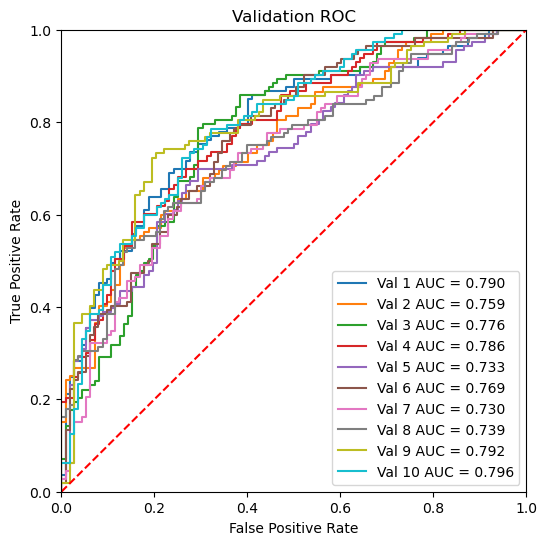

In [210]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

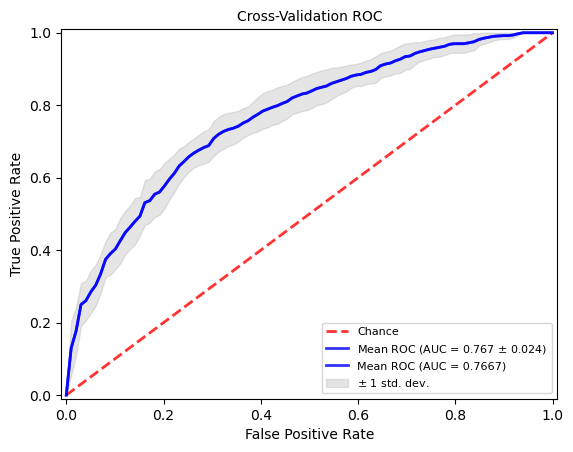

In [211]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [212]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [213]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [214]:
my_calculate_metrics_list_val

[{'SN': 0.8495575221238938,
  'SP': 0.5982142857142857,
  'ACC': 0.7244444444444444,
  'MCC': 0.46286653238269454,
  'Recall': 0.8495575221238938,
  'Precision': 0.6808510638297872,
  'F1-score': 0.7559055118110236,
  'Cutoff': 0.5},
 {'SN': 0.4017857142857143,
  'SP': 0.9196428571428571,
  'ACC': 0.6607142857142857,
  'MCC': 0.37573457465108967,
  'Recall': 0.4017857142857143,
  'Precision': 0.8333333333333334,
  'F1-score': 0.5421686746987951,
  'Cutoff': 0.5},
 {'SN': 0.7610619469026548,
  'SP': 0.7053571428571429,
  'ACC': 0.7333333333333333,
  'MCC': 0.46719494683571394,
  'Recall': 0.7610619469026548,
  'Precision': 0.7226890756302521,
  'F1-score': 0.7413793103448276,
  'Cutoff': 0.5},
 {'SN': 0.8053097345132744,
  'SP': 0.5535714285714286,
  'ACC': 0.68,
  'MCC': 0.37097931711349896,
  'Recall': 0.8053097345132744,
  'Precision': 0.6453900709219859,
  'F1-score': 0.7165354330708661,
  'Cutoff': 0.5},
 {'SN': 0.4778761061946903,
  'SP': 0.8125,
  'ACC': 0.6444444444444445,
  'MC

In [215]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.849558,0.598214,0.724444,0.462867,0.849558,0.680851,0.755906,0.5
1,0.401786,0.919643,0.660714,0.375735,0.401786,0.833333,0.542169,0.5
2,0.761062,0.705357,0.733333,0.467195,0.761062,0.722689,0.741379,0.5
3,0.805310,0.553571,0.680000,0.370979,0.805310,0.645390,0.716535,0.5
4,0.477876,0.812500,0.644444,0.307987,0.477876,0.720000,0.574468,0.5
5,0.812500,0.575221,0.693333,0.398943,0.812500,0.654676,0.725100,0.5
6,0.857143,0.407080,0.631111,0.295684,0.857143,0.588957,0.698182,0.5
7,0.776786,0.513274,0.644444,0.300575,0.776786,0.612676,0.685039,0.5
8,0.633929,0.840708,0.737778,0.485339,0.633929,0.797753,0.706468,0.5
9,0.857143,0.491071,0.674107,0.374188,0.857143,0.627451,0.724528,0.5


In [216]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.849558,0.598214,0.724444,0.462867,0.849558,0.680851,0.755906,0.5
1,0.401786,0.919643,0.660714,0.375735,0.401786,0.833333,0.542169,0.5
2,0.761062,0.705357,0.733333,0.467195,0.761062,0.722689,0.741379,0.5
3,0.805310,0.553571,0.680000,0.370979,0.805310,0.645390,0.716535,0.5
4,0.477876,0.812500,0.644444,0.307987,0.477876,0.720000,0.574468,0.5
5,0.812500,0.575221,0.693333,0.398943,0.812500,0.654676,0.725100,0.5
6,0.857143,0.407080,0.631111,0.295684,0.857143,0.588957,0.698182,0.5
7,0.776786,0.513274,0.644444,0.300575,0.776786,0.612676,0.685039,0.5
8,0.633929,0.840708,0.737778,0.485339,0.633929,0.797753,0.706468,0.5
9,0.857143,0.491071,0.674107,0.374188,0.857143,0.627451,0.724528,0.5


In [217]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [218]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [219]:
roc_auc_list_indep

[0.7613998724489797,
 0.7730389030612244,
 0.7799744897959183,
 0.7655452806122448,
 0.7857142857142858,
 0.7615593112244899,
 0.757095025510204,
 0.7587691326530612,
 0.7880261479591838,
 0.7802933673469389]

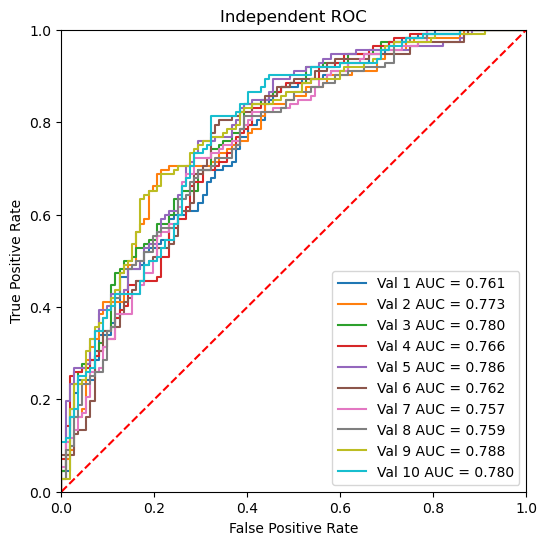

In [222]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

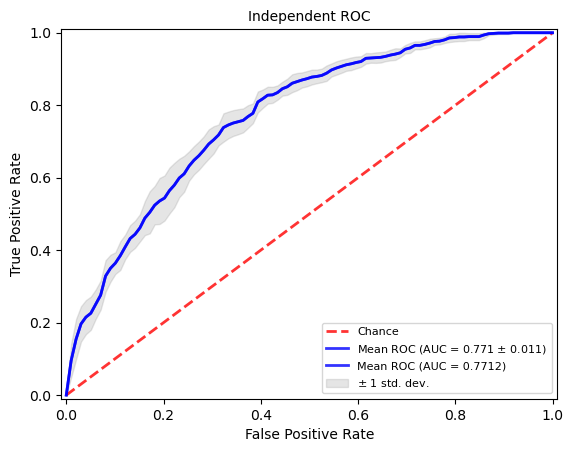

In [223]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [224]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [225]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [226]:
my_calculate_metrics_list_indep

[{'SN': 0.8214285714285714,
  'SP': 0.5625,
  'ACC': 0.6919642857142857,
  'MCC': 0.39748418438347904,
  'Recall': 0.8214285714285714,
  'Precision': 0.6524822695035462,
  'F1-score': 0.7272727272727273,
  'Cutoff': 0.5},
 {'SN': 0.4017857142857143,
  'SP': 0.9107142857142857,
  'ACC': 0.65625,
  'MCC': 0.36303069517251496,
  'Recall': 0.4017857142857143,
  'Precision': 0.8181818181818182,
  'F1-score': 0.5389221556886228,
  'Cutoff': 0.5},
 {'SN': 0.6964285714285714,
  'SP': 0.6875,
  'ACC': 0.6919642857142857,
  'MCC': 0.383943875618936,
  'Recall': 0.6964285714285714,
  'Precision': 0.6902654867256637,
  'F1-score': 0.6933333333333334,
  'Cutoff': 0.5},
 {'SN': 0.8392857142857143,
  'SP': 0.5714285714285714,
  'ACC': 0.7053571428571429,
  'MCC': 0.4262915590312234,
  'Recall': 0.8392857142857143,
  'Precision': 0.6619718309859155,
  'F1-score': 0.7401574803149606,
  'Cutoff': 0.5},
 {'SN': 0.45535714285714285,
  'SP': 0.8571428571428571,
  'ACC': 0.65625,
  'MCC': 0.3412564092821245

In [227]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.821429,0.562500,0.691964,0.397484,0.821429,0.652482,0.727273,0.5
1,0.401786,0.910714,0.656250,0.363031,0.401786,0.818182,0.538922,0.5
2,0.696429,0.687500,0.691964,0.383944,0.696429,0.690265,0.693333,0.5
3,0.839286,0.571429,0.705357,0.426292,0.839286,0.661972,0.740157,0.5
4,0.455357,0.857143,0.656250,0.341256,0.455357,0.761194,0.569832,0.5
5,0.821429,0.607143,0.714286,0.438763,0.821429,0.676471,0.741935,0.5
6,0.839286,0.500000,0.669643,0.360680,0.839286,0.626667,0.717557,0.5
7,0.812500,0.598214,0.705357,0.420482,0.812500,0.669118,0.733871,0.5
8,0.526786,0.848214,0.687500,0.396015,0.526786,0.776316,0.627660,0.5
9,0.883929,0.562500,0.723214,0.471446,0.883929,0.668919,0.761538,0.5


In [228]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.821429,0.562500,0.691964,0.397484,0.821429,0.652482,0.727273,0.5
1,0.401786,0.910714,0.656250,0.363031,0.401786,0.818182,0.538922,0.5
2,0.696429,0.687500,0.691964,0.383944,0.696429,0.690265,0.693333,0.5
3,0.839286,0.571429,0.705357,0.426292,0.839286,0.661972,0.740157,0.5
4,0.455357,0.857143,0.656250,0.341256,0.455357,0.761194,0.569832,0.5
5,0.821429,0.607143,0.714286,0.438763,0.821429,0.676471,0.741935,0.5
6,0.839286,0.500000,0.669643,0.360680,0.839286,0.626667,0.717557,0.5
7,0.812500,0.598214,0.705357,0.420482,0.812500,0.669118,0.733871,0.5
8,0.526786,0.848214,0.687500,0.396015,0.526786,0.776316,0.627660,0.5
9,0.883929,0.562500,0.723214,0.471446,0.883929,0.668919,0.761538,0.5


In [229]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\amodel\DL\new\CNN_OH_迁移数据\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [230]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

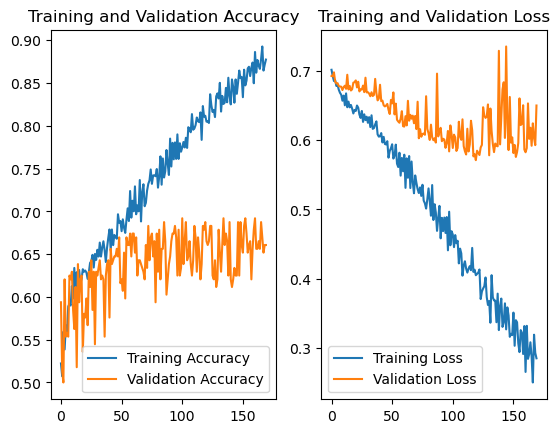

In [231]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()